# Comparison of various PPCA models
In this notebook, we compare my PPCA solution (both the closed-form solution and the EM algorithm) with various solutions found online.

In [138]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

os.sys.path.append('Other_examples/')
import PPCA_angermueller as ppca_angermueller
import ppca_ymcdull
import pystan

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
import functools
import warnings
tf.enable_v2_behavior()
import ppca as ppca_tran
import pyppca

### General dataset to be tested

In [139]:
N=5000
M=2
D=3

In [140]:
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.lognormal(0,1)
mu = np.random.normal(0,5,size=(D,1))
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z)+mu,sigma)
print('mu: ', mu)
print('sigma: ', sigma)
print('W: ', W)

mu:  [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
sigma:  3.2808232206458503
W:  [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]


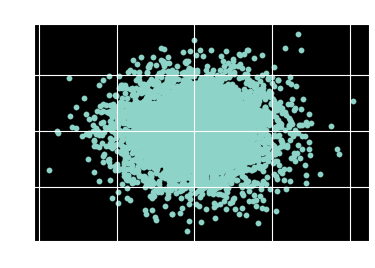

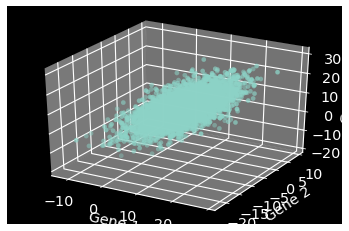

In [141]:
plt.figure()
plt.scatter(z[0,:], z[1,:])
plt.title('latent data')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:])
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

# Closed-form solutions

## My solution
This approach was built by me and lives in this repository.

In [142]:
mu_ML = np.mean(x,axis=1)[np.newaxis].T
S = np.cov(x)
eigenvalues, eigenvectors = np.linalg.eig(S)
order = np.argsort(eigenvalues)[::-1]
eigenvalues = np.sort(eigenvalues)[::-1]
eigenvectors = eigenvectors[order]
sigma_ML = 0.0
for i in range(M,D):
    sigma_ML += eigenvalues[i]
sigma_ML = sigma_ML/(D-M)
U = eigenvectors[:M].T
L = np.diag(eigenvalues[:M])
R = np.eye(M)
W_ML = np.matmul(np.matmul(U,np.sqrt((L-sigma_ML*np.eye(M)))),R)
x_sim_closed = np.random.normal(np.matmul(W_ML,z)+mu_ML,sigma_ML)

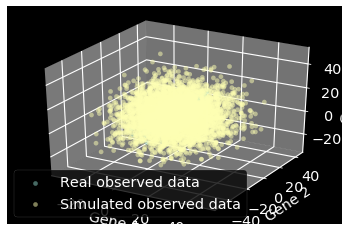

In [143]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.5, label='Real observed data')
ax.scatter(x_sim_closed[0,:],x_sim_closed[1,:],x_sim_closed[2,:], alpha=0.5, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [144]:
mu_ML_closed_me = mu_ML.copy()
sigma_ML_closed_me = sigma_ML.copy()
W_ML_closed_me = W_ML.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML_closed_me)
print()
print('sigma: ', sigma)
print('sigma_ML: ', sigma_ML_closed_me)
print()
print('W: ', W)
print('W_ML: ', W_ML_closed_me)

mu:  [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
mu_ML:  [[ 8.78219692]
 [-5.4722644 ]
 [ 6.84708398]]

sigma:  3.2808232206458503
sigma_ML:  11.073627488821499

W:  [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]
W_ML:  [[-4.05441776 -1.73074366]
 [-5.195941    0.84088146]
 [-2.23753134  1.18344146]]


## Angermuellers PPCA
This solution is taken from https://github.com/cangermueller/ppca to compare with my approach. The original code has been altered slightly for compatibility purposes.

In [145]:
ppca = ppca_angermueller.PPCA()
ppca.fit(x)
z_angermueller = ppca.transform()
x_angermueller = np.random.normal(np.matmul(ppca.w,z)+ppca.mu,ppca.sigma)

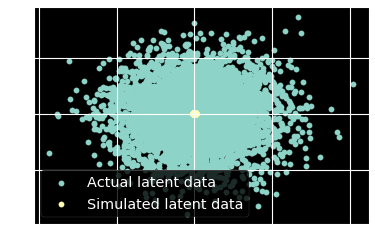

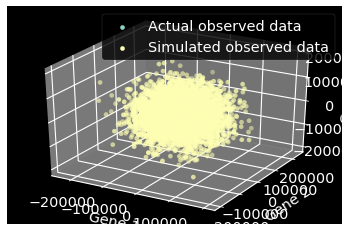

In [146]:
plt.scatter(z[0,:], z[1,:], label='Actual latent data')
plt.scatter(z_angermueller[0,:],z_angermueller[1,:], label='Simulated latent data')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual observed data')
ax.scatter(x_angermueller[0,:],x_angermueller[1,:],x_angermueller[2,:], label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [147]:
mu_ML_angermueller = ppca.mu.copy()
sigma_ML_angermueller = ppca.sigma.copy()
W_ML_angermueller = ppca.w.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML_angermueller)
print()
print('sigma: ', sigma)
print('sigma_ML: ', sigma_ML_angermueller)
print()
print('W: ', W)
print('W_ML: ', W_ML_angermueller)

mu:  [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
mu_ML:  [[ 8.78219692]
 [-5.4722644 ]
 [ 6.84708398]]

sigma:  3.2808232206458503
sigma_ML:  55357.06381661866

W:  [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]
W_ML:  [[-317.74100561   91.41958346]
 [-148.05096243  224.3105522 ]
 [-417.90244174 -148.97530452]]


# EM solutions

## My solution
This approach was built by me and lives in this repository.

In [148]:
for iteration in range(50):
    S = np.cov(x)
    M_mat = sigma_ML*np.eye(M) + np.matmul(W_ML.T,W_ML)
    W_ML_new = np.matmul(np.matmul(S,W_ML),np.linalg.inv(sigma_ML*np.eye(M)+np.matmul(np.matmul(np.matmul(np.linalg.inv(M_mat),W_ML.T),S),W_ML)))
    sigma_ML = np.trace(S-np.matmul(np.matmul(np.matmul(S,W_ML),np.linalg.inv(M_mat)),W_ML_new.T))/D
    W_ML = W_ML_new.copy()
x_sim_em = np.random.normal(np.matmul(W_ML,z)+mu_ML,sigma_ML)

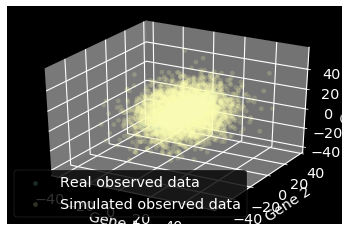

In [149]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2, label='Real observed data')
ax.scatter(x_sim_em[0,:],x_sim_em[1,:],x_sim_em[2,:], alpha=0.2, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [150]:
mu_ML_em_me = mu_ML.copy()
sigma_ML_em_me = sigma_ML.copy()
W_ML_em_me = W_ML.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML_em_me)
print()
print('sigma: ', sigma)
print('sigma_ML: ', sigma_ML_em_me)
print()
print('W: ', W)
print('W_ML: ', W_ML_em_me)

mu:  [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
mu_ML:  [[ 8.78219692]
 [-5.4722644 ]
 [ 6.84708398]]

sigma:  3.2808232206458503
sigma_ML:  11.074058170712377

W:  [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]
W_ML:  [[-4.09190639 -0.47067766]
 [-1.99706839 -1.65987717]
 [-5.24779272  1.51518187]]


## Angermuellers algorithm
This algorithm is taken from https://github.com/cangermueller/ppca to compare with my approach. The original code has been altered slightly for compatibility purposes.

In [151]:
ppca = ppca_angermueller.PPCA()
ppca.fit(x, em=True)
z_angermueller_em = ppca.transform()
x_angermueller_em = np.random.normal(np.matmul(ppca.w,z)+ppca.mu,ppca.sigma)

  1  -7.929
  2  -6.675
  3  -6.473
  4  -6.378
  5  -6.318
  6  -6.276
  7  -6.245
  8  -6.220
  9  -6.199
 10  -6.183
 11  -6.169
 12  -6.158
 13  -6.148
 14  -6.141
 15  -6.134
 16  -6.129
 17  -6.125
 18  -6.121
 19  -6.119
 20  -6.116


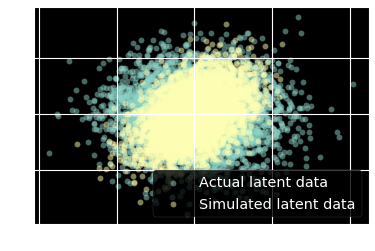

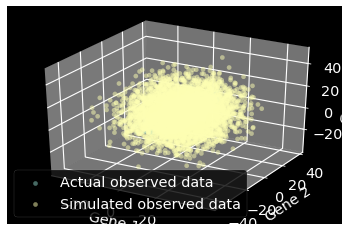

In [152]:
plt.scatter(z[0,:], z[1,:], label='Actual latent data', alpha=0.5)
plt.scatter(z_angermueller_em[0,:],z_angermueller_em[1,:], label='Simulated latent data', alpha=0.5)
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual observed data', alpha=0.5)
ax.scatter(x_angermueller_em[0,:],x_angermueller_em[1,:],x_angermueller_em[2,:], label='Simulated observed data', alpha=0.5)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

In [153]:
mu_ML_angermueller_em = ppca.mu.copy()
sigma_ML_angermueller_em = ppca.sigma.copy()
W_ML_angermueller_em = ppca.w.copy()

print('mu: ', mu)
print('mu_ML: ', mu_ML_angermueller_em)
print()
print('sigma: ', sigma)
print('sigma_ML: ', sigma_ML_angermueller_em)
print()
print('W: ', W)
print('W_ML: ', W_ML_angermueller_em)

mu:  [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
mu_ML:  [[ 8.78219692]
 [-5.4722644 ]
 [ 6.84708398]]

sigma:  3.2808232206458503
sigma_ML:  11.147861415959117

W:  [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]
W_ML:  [[2.86478548 2.94438065]
 [2.51380565 0.57107593]
 [2.02443349 5.05681784]]


## Ymcdulls algorithm

In [154]:
ppca = ppca_ymcdull.PPCA(D = 2, n_iters = 100, verbose = True)
ppca.fit(x.T)

Lower bound: -69900.3808412018
0
Lower bound: -56450.507678086426
1
Lower bound: -52740.874991691584
2
Lower bound: -51342.83069672752
3
Lower bound: -50711.60904967688
4
Lower bound: -50388.38056414691
5
Lower bound: -50208.11895397172
6
Lower bound: -50101.32109258691
7
Lower bound: -50035.16557252224
8
Lower bound: -49992.78616200735
9
Lower bound: -49964.9297580397
10
Lower bound: -49946.24928616278
11
Lower bound: -49933.52324240118
12
Lower bound: -49924.74421708328
13
Lower bound: -49918.6266390481
14
Lower bound: -49914.32863384782
15
Lower bound: -49911.28871945849
16
Lower bound: -49909.12674729817
17
Lower bound: -49907.58212312156
18
Lower bound: -49906.47435716618
19
Lower bound: -49905.677362462084
20
Lower bound: -49905.10242151478
21
Lower bound: -49904.686732978385
22
Lower bound: -49904.38561445276
23
Lower bound: -49904.16713816961
24
Lower bound: -49904.0084071342
25
Lower bound: -49903.8929500952
26
Lower bound: -49903.80888715301
27
Lower bound: -49903.74763091472

[[ 8.46565673  3.95627477]
 [-1.91750277 -5.37704777]
 [ 8.06973777  2.36154412]]
0.06996617646268997
[[-0.26746063  1.08256231]
 [ 0.65069134  0.29884171]
 [-1.11060342  1.57734561]
 ...
 [ 1.49428958  0.12368898]
 [-0.49397547  1.10862605]
 [ 1.46775575  0.46138157]]


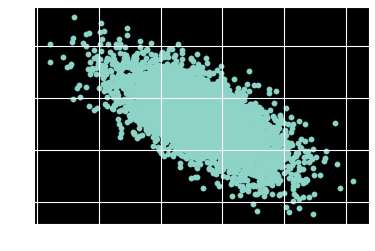

In [155]:
ymcdull_w = ppca.e_w
ymcdull_tau = ppca.e_tau
ymcdull_x = ppca.e_X

print(ymcdull_w)
print(ymcdull_tau)
print(ymcdull_x)
plt.scatter(ymcdull_x[:, 0], ymcdull_x[:, 1])
plt.show()

# PyStan

In [156]:
latent_mu = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    matrix[N,D] x;//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    for (d in 1:D){
        W[d] ~ normal(0.0,sigma);
        mu[d]~normal(0.0, 5.0) ;
        }
    sigma~lognormal(0.0, 1.0) ;
    
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n)+mu, sigma);
}
"""
ppca = pystan.StanModel(model_code=latent_mu)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_97b5609a35425dcdc7914eae6f54f7bd NOW.


In [157]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}
op = ppca.optimizing(data=ppca_dat)

z_sim_pystan = op['z'].T
sigma_sim_pystan = op['sigma']
W_sim_pystan = op['W'].T
mu_sim_pystan = op['mu'].T
x_sim_pystan = np.random.normal(np.matmul(z_sim_pystan,W_sim_pystan)+mu_sim_pystan,sigma_sim_pystan)

print('real mu: ', mu)
print('simulated mu: ', mu_sim_pystan)
print()
print('real sigma: ', sigma)
print('simulated sigma: ', sigma_sim_pystan)
print()
print('real z: ', z)
print('simulated z: ', z_sim_pystan)
print()
print('real W: ', W)
print('simulated W: ', W_sim_pystan)
print()

real mu:  [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
simulated mu:  [ 8.74443257 -5.47500198  6.77611162]

real sigma:  3.2808232206458503
simulated sigma:  1.9483507384914918

real z:  [[ 1.52350821 -0.61217047  2.95350225 ... -1.79664499  0.8474644
  -1.72607122]
 [-1.07981919  0.82010076 -0.6546993  ...  0.65568095 -0.29273538
   0.64412884]]
simulated z:  [[-0.31014383 -0.1418088 ]
 [ 0.13180545 -0.17170965]
 [-0.49893418 -0.38263763]
 ...
 [ 0.21441795  0.20898441]
 [-0.28069028 -0.30655444]
 [ 0.1679398   0.26268761]]

real W:  [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]
simulated W:  [[18.97681345 19.06650413  9.79484421]
 [ 7.42583246 -7.46665219 25.97460417]]



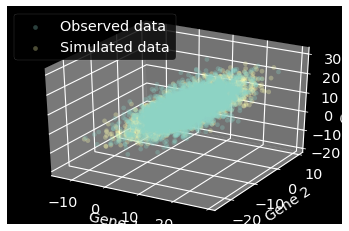

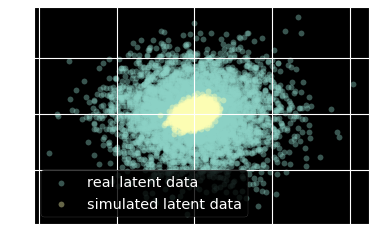

In [158]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Observed data', alpha=0.3)
ax.scatter(x_sim_pystan[:,0],x_sim_pystan[:,1],x_sim_pystan[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.scatter(z[0,:], z[1,:], label='real latent data', alpha=0.4)
plt.scatter(z_sim_pystan[:,0], z_sim_pystan[:,1], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()

In [159]:
print('mu: ', mu)
print('mu_ML: ', mu_sim_pystan)
print()
print('sigma: ', sigma)
print('sigma_ML: ', sigma_sim_pystan)
print()
print('W: ', W)
print('W_ML: ', W_sim_pystan)

mu:  [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
mu_ML:  [ 8.74443257 -5.47500198  6.77611162]

sigma:  3.2808232206458503
sigma_ML:  1.9483507384914918

W:  [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]
W_ML:  [[18.97681345 19.06650413  9.79484421]
 [ 7.42583246 -7.46665219 25.97460417]]


# TensorFlow

In [160]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca_mu(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=3.0*tf.ones([data_dim,1]),
                 scale=5.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)
    
x_train = tf.convert_to_tensor(x,dtype=tf.float32)
concrete_ppca_model_mu = functools.partial(probabilistic_pca_mu,
    data_dim=D,
    latent_dim=M,
    num_datapoints=N,
    stddv_datapoints=sigma)

model_mu = tfd.JointDistributionCoroutine(concrete_ppca_model_mu)

w_tf = tf.Variable(np.ones([D, M]), dtype=tf.float32)
z_tf = tf.Variable(np.ones([M, N]), dtype=tf.float32)
mu_tf = tf.expand_dims(tf.reduce_mean(x_train, 1),1)

target_log_prob_fn_mu = lambda w_tf, z_tf, mu_tf: model_mu.log_prob((w_tf, z_tf, mu_tf, x_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(w_tf, z_tf, mu_tf),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)

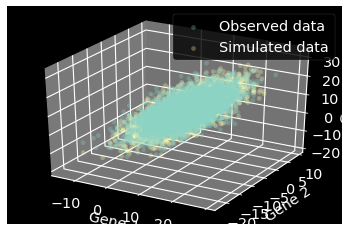

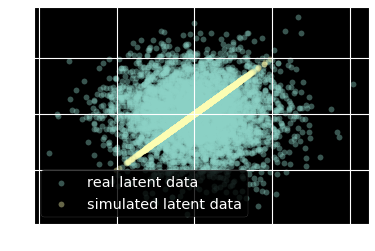

In [161]:
_, _, _, x_generated_mu = model_mu.sample(value=(w_tf, z_tf, mu_tf, None))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], label='Observed data', alpha=0.3)
ax.scatter(x_generated_mu[0,:],x_generated_mu[1,:],x_generated_mu[2,:], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.scatter(z[0,:], z[1,:], label='real latent data', alpha=0.4)
plt.scatter(z_tf[0,:], z_tf[1,:], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()

In [162]:
print('mu: ', mu)
print('mu_ML: ', mu_tf)
print()
print('W: ', W)
print('W_ML: ', w_tf)

mu:  [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
mu_ML:  tf.Tensor(
[[ 8.782197 ]
 [-5.4722643]
 [ 6.8470845]], shape=(3, 1), dtype=float32)

W:  [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]
W_ML:  <tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[4.1500235, 4.1500235],
       [1.9577615, 1.9577615],
       [5.386509 , 5.386509 ]], dtype=float32)>


## PPCA library by Allen Tran
 As published on https://pypi.org/project/ppca/

In [163]:
# ppca_tran = ppca_tran.PPCA()
# ppca_tran.fit(x, tol=1e-2, verbose=False)
# ppca_tran.transform()

Unfortunately, mostly due to the scarcity of its documentation, no solutions were derived by use of this package.

## Pyppca library by Sheridan Green
As published on https://pypi.org/project/pyppca/

In [164]:
C_pyppca, ss_pyppca, M_pyppca, X_pyppca, Ye_pyppca = pyppca.ppca(x.T, d=M, dia=False)

In [165]:
print('mu: ', mu)
print('mu_ML: ', M_pyppca)
print()
print('sigma: ', sigma)
print('sigma_ML: ', ss_pyppca)

mu:  [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
mu_ML:  [ 8.78219692 -5.4722644   6.84708398]

sigma:  3.2808232206458503
sigma_ML:  11.51365423538946


# Overall Comparison

## Closed solutions

In [166]:
print('real mu:\n', mu)
print('my solution:\n', mu_ML_closed_me)
print('Angermuellers solution:\n',mu_ML_angermueller)
print()
print()
print('real sigma: ', sigma)
print('my solution: ', sigma_ML_closed_me)
print('Angermuellers solution: ',sigma_ML_angermueller)
print()
print('real W:\n', W)
print('my solution:\n', W_ML_closed_me)
print('Angermuellers solution:\n',W_ML_angermueller)

real mu:
 [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
my solution:
 [[ 8.78219692]
 [-5.4722644 ]
 [ 6.84708398]]
Angermuellers solution:
 [[ 8.78219692]
 [-5.4722644 ]
 [ 6.84708398]]


real sigma:  3.2808232206458503
my solution:  11.073627488821499
Angermuellers solution:  55357.06381661866

real W:
 [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]
my solution:
 [[-4.05441776 -1.73074366]
 [-5.195941    0.84088146]
 [-2.23753134  1.18344146]]
Angermuellers solution:
 [[-317.74100561   91.41958346]
 [-148.05096243  224.3105522 ]
 [-417.90244174 -148.97530452]]


## Iterative solutions

In [167]:
print('real mu:\n', mu)
print('my solution:\n', mu_ML_em_me)
print('Angermuellers solution:\n',mu_ML_angermueller_em)
print('Ymcdulls solution:\nnot included')
print('PyStans solution:\n', mu_sim_pystan)
print('TensorFlows solution:\n', mu_tf.numpy())
print('PyPPCAs solution:\n', M_pyppca)
print()
print()
print('real sigma: ', sigma)
print('my solution: ', sigma_ML_em_me)
print('Angermuellers solution: ',sigma_ML_angermueller_em)
print('Ymcdulls solution: ', ymcdull_tau)
print('PyStans solution: ', sigma_sim_pystan)
print('TensorFlows solution: not included')
print('PyPPCAs solution:\n', ss_pyppca)
print()
print('real W:\n', W)
print('my solution:\n', W_ML_em_me)
print('Angermuellers solution:\n',W_ML_angermueller_em)
print('Ymcdulls solution:\n', ymcdull_w)
print('PyStans solution:\n', W_sim_pystan)
print('TensorFlows solution:\n', w_tf.numpy())
print('PyPPCAs solution: not included' )

real mu:
 [[ 8.87106514]
 [-5.50055066]
 [ 6.92905581]]
my solution:
 [[ 8.78219692]
 [-5.4722644 ]
 [ 6.84708398]]
Angermuellers solution:
 [[ 8.78219692]
 [-5.4722644 ]
 [ 6.84708398]]
Ymcdulls solution:
not included
PyStans solution:
 [ 8.74443257 -5.47500198  6.77611162]
TensorFlows solution:
 [[ 8.782197 ]
 [-5.4722643]
 [ 6.8470845]]
PyPPCAs solution:
 [ 8.78219692 -5.4722644   6.84708398]


real sigma:  3.2808232206458503
my solution:  11.074058170712377
Angermuellers solution:  11.147861415959117
Ymcdulls solution:  0.06996617646268997
PyStans solution:  1.9483507384914918
TensorFlows solution: not included
PyPPCAs solution:
 11.51365423538946

real W:
 [[-4.05501034  0.01938241]
 [-2.18606686  1.50227798]
 [-4.91633699 -2.17517216]]
my solution:
 [[-4.09190639 -0.47067766]
 [-1.99706839 -1.65987717]
 [-5.24779272  1.51518187]]
Angermuellers solution:
 [[2.86478548 2.94438065]
 [2.51380565 0.57107593]
 [2.02443349 5.05681784]]
Ymcdulls solution:
 [[ 8.46565673  3.95627477]
 [-1

All models generate virtually the same vlaue for $\mu$. $\sigma^2$ is never estimated correctly, but the solutions I based on Tipping & Bishops paper and PyStans solution come closest. 

### Visual representation of simulated  latent data

Angermueller: closed form


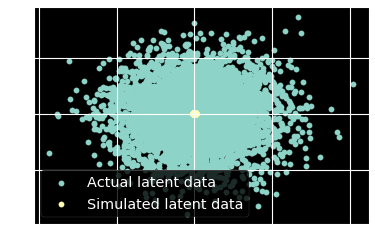

Mean of actual latent data:  [0.01830659 0.00208046]
Mean of simulated latent data:  [-1.89848137e-18  7.54951657e-19]
Covariance of actual latent data:
 [[ 1.0141536  -0.00398595]
 [-0.00398595  0.96870242]]
Covariance of simulated latent data:
 [[1.42201506e-04 2.82816490e-20]
 [2.82816490e-20 7.04944033e-05]]

Angermueller: iterative


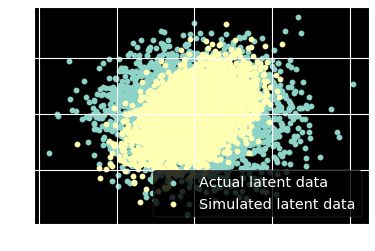

Mean of actual latent data:  [0.01830659 0.00208046]
Mean of simulated latent data:  [1.17950094e-16 8.81072992e-17]
Covariance of actual latent data:
 [[ 1.0141536  -0.00398595]
 [-0.00398595  0.96870242]]
Covariance of simulated latent data:
 [[0.46876508 0.23464441]
 [0.23464441 0.65480184]]

Ymcdulls solution


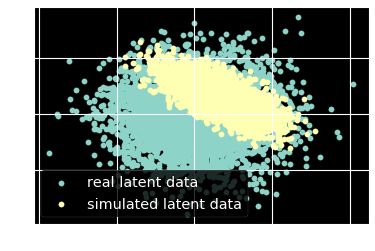

Mean of actual latent data:  [0.01830659 0.00208046]
Mean of simulated latent data:  [0.66062008 0.60237797]
Covariance of actual latent data:
 [[ 1.0141536  -0.00398595]
 [-0.00398595  0.96870242]]
Covariance of simulated latent data:
 [[ 0.43924478 -0.2357074 ]
 [-0.2357074   0.27958941]]

PyStan


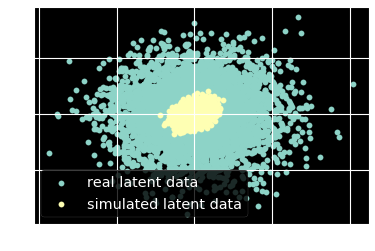

Mean of actual latent data:  [0.01830659 0.00208046]
Mean of simulated latent data:  [0.00106379 0.00232278]
Covariance of actual latent data:
 [[ 1.0141536  -0.00398595]
 [-0.00398595  0.96870242]]
Covariance of simulated latent data:
 [[0.04339588 0.01341502]
 [0.01341502 0.04161963]]

TensorFlow


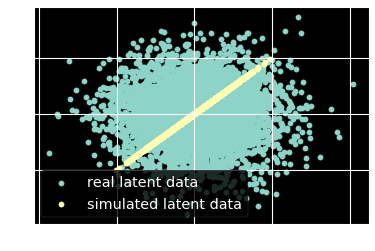

Mean of actual latent data:  [0.01830659 0.00208046]
Mean of simulated latent data:  [-0.00019265 -0.00019265]
Covariance of actual latent data:
 [[ 1.0141536  -0.00398595]
 [-0.00398595  0.96870242]]
Covariance of simulated latent data:
 [[0.28251568 0.28251568]
 [0.28251568 0.28251568]]

PyPPCA


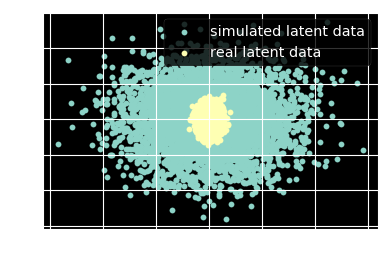

Mean of actual latent data:  [0.01830659 0.00208046]
Mean of simulated latent data:  [-1.48894230e-15 -5.88018523e-16]
Covariance of actual latent data:
 [[ 1.0141536  -0.00398595]
 [-0.00398595  0.96870242]]
Covariance of simulated latent data:
 [[5.95162802e+01 2.35947378e-16]
 [2.35947378e-16 1.61754038e+01]]

Best simulated mean in terms of sum of squares:  PyStans solution
Best simulated covariance in terms of sum of squares:  Angermuellers iterative solution


In [168]:
real_latent_mean = np.mean(z, axis=1)
real_latent_cov = np.cov(z)

print('Angermueller: closed form')
plt.scatter(z[0,:], z[1,:], label='Actual latent data')
plt.scatter(z_angermueller[0,:],z_angermueller[1,:], label='Simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(z_angermueller, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(z_angermueller))
print()

print('Angermueller: iterative')
plt.scatter(z[0,:], z[1,:], label='Actual latent data')
plt.scatter(z_angermueller_em[0,:],z_angermueller_em[1,:], label='Simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(z_angermueller_em, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(z_angermueller_em))
print()

print('Ymcdulls solution')
plt.scatter(z[0,:], z[1,:], label='real latent data')
plt.scatter(ymcdull_x[:, 0], ymcdull_x[:, 1], label='simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(ymcdull_x.T, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(ymcdull_x.T))
print()

print('PyStan')
plt.scatter(z[0,:], z[1,:], label='real latent data')
plt.scatter(z_sim_pystan[:,0], z_sim_pystan[:,1], label='simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(z_sim_pystan.T, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(z_sim_pystan.T))
print()

print('TensorFlow')
plt.scatter(z[0,:], z[1,:], label='real latent data')
plt.scatter(z_tf[0,:], z_tf[1,:], label='simulated latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(z_tf.numpy(), axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(z_tf.numpy()))
print()

print('PyPPCA')
plt.scatter(X_pyppca[:,0], X_pyppca[:,1], label='simulated latent data')
plt.scatter(z[0,:], z[1,:], label='real latent data')
plt.legend()
plt.show()
print('Mean of actual latent data: ', real_latent_mean)
print('Mean of simulated latent data: ',np.mean(X_pyppca.T, axis=1))
print('Covariance of actual latent data:\n', real_latent_cov)
print('Covariance of simulated latent data:\n',np.cov(X_pyppca.T))
print()

min_mu = 10000
min_cov = 10000
solutions = ['Angermuellers closed solution', 'Angermuellers iterative solution', 'Ymcdulls solution', 'PyStans solution', 'TensorFlows solution', 'PyPPCAs solution']
solutions_var = [z_angermueller, z_angermueller_em,ymcdull_x.T, z_sim_pystan.T, z_tf.numpy(), X_pyppca.T]
for i in range(len(solutions)):
    if sum((np.mean(solutions_var[i], axis=1)-real_latent_mean)**2)<min_mu:
        min_mu = sum((np.mean(solutions_var[i], axis=1)-real_latent_mean)**2)
        best_solution_mu = solutions[i]
    if sum(sum((np.cov(solutions_var[i])-real_latent_cov)**2))<min_cov:
        min_cov = sum(sum((np.cov(solutions_var[i])-real_latent_cov)**2))
        best_solution_cov = solutions[i]
print('Best simulated mean in terms of sum of squares: ', best_solution_mu)
print('Best simulated covariance in terms of sum of squares: ', best_solution_cov)

## Visual representation of simulated observed data

my ppca: closed form


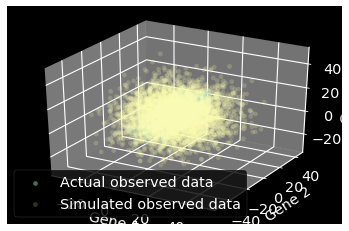

Mean of actual data:  [ 8.78219692 -5.4722644   6.84708398]
Mean of simulated data:  [ 8.84320523 -5.78634624  6.73180543]
Covariance of actual data:
 [[28.03933495  8.95346231 20.76070076]
 [ 8.95346231 17.81766676  7.96510719]
 [20.76070076  7.96510719 40.90962246]]
Covariance of simulated data:
 [[149.59604599  15.42221759   6.23922244]
 [ 15.42221759 153.64935219  13.40917513]
 [  6.23922244  13.40917513 127.26507732]]

Angermueller: closed form


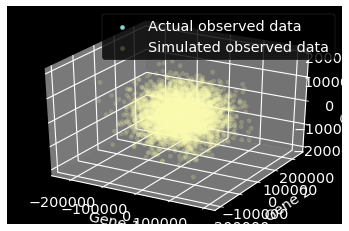

Mean of actual data:  [ 8.78219692 -5.4722644   6.84708398]
Mean of simulated data:  [ 1268.23527034 -1170.92100134  -468.635188  ]
Covariance of actual data:
 [[28.03933495  8.95346231 20.76070076]
 [ 8.95346231 17.81766676  7.96510719]
 [20.76070076  7.96510719 40.90962246]]
Covariance of simulated data:
 [[ 3.04816675e+09 -2.92624248e+07 -1.32512640e+07]
 [-2.92624248e+07  3.02418965e+09 -4.18381466e+06]
 [-1.32512640e+07 -4.18381466e+06  2.96986977e+09]]

my ppca: iterative


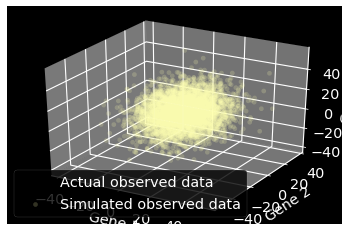

Mean of actual data:  [ 8.78219692 -5.4722644   6.84708398]
Mean of simulated data:  [ 8.60959019 -5.38635268  6.56249981]
Covariance of actual data:
 [[28.03933495  8.95346231 20.76070076]
 [ 8.95346231 17.81766676  7.96510719]
 [20.76070076  7.96510719 40.90962246]]
Covariance of simulated data:
 [[142.33732809  11.37281913  21.77654305]
 [ 11.37281913 135.49871586  11.15065803]
 [ 21.77654305  11.15065803 156.22586859]]

Angermueller: iterative


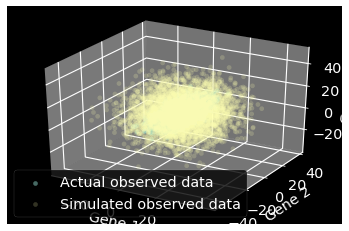

Mean of actual data:  [ 8.78219692 -5.4722644   6.84708398]
Mean of simulated data:  [ 8.71032763 -5.28956492  6.78463861]
Covariance of actual data:
 [[28.03933495  8.95346231 20.76070076]
 [ 8.95346231 17.81766676  7.96510719]
 [20.76070076  7.96510719 40.90962246]]
Covariance of simulated data:
 [[139.49790979   8.22409072  19.27605576]
 [  8.22409072 129.36605034   7.63560928]
 [ 19.27605576   7.63560928 153.19012207]]

PyStan


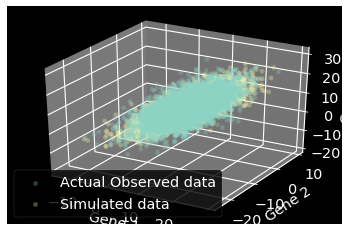

Mean of actual data:  [ 8.78219692 -5.4722644   6.84708398]
Mean of simulated data:  [ 8.78229142 -5.50169443  6.86716904]
Covariance of actual data:
 [[28.03933495  8.95346231 20.76070076]
 [ 8.95346231 17.81766676  7.96510719]
 [20.76070076  7.96510719 40.90962246]]
Covariance of simulated data:
 [[25.70734437 14.0708761  23.50393293]
 [14.0708761  18.31144725  6.16332786]
 [23.50393293  6.16332786 43.00968237]]

TensorFlow


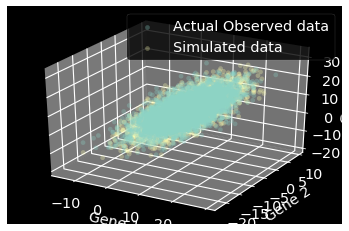

Mean of actual data:  [ 8.78219692 -5.4722644   6.84708398]
Mean of simulated data:  [ 8.801903  -5.4947367  6.848561 ]
Covariance of actual data:
 [[28.03933495  8.95346231 20.76070076]
 [ 8.95346231 17.81766676  7.96510719]
 [20.76070076  7.96510719 40.90962246]]
Covariance of simulated data:
 [[30.14120984  9.29973925 25.36673806]
 [ 9.29973925 15.38948267 11.78667897]
 [25.36673806 11.78667897 43.93163074]]

Best simulated mean in terms of sum of squares:  TensorFlows solution
Best simulated covariance in terms of sum of squares:  PyStans solution


In [169]:
real_mean = np.mean(x, axis=1)
real_cov = np.cov(x)

print('my ppca: closed form')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.5, label='Actual observed data')
ax.scatter(x_sim_closed[0,:],x_sim_closed[1,:],x_sim_closed[2,:], alpha=0.2, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_sim_closed, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_sim_closed))
print()

print('Angermueller: closed form')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual observed data')
ax.scatter(x_angermueller[0,:],x_angermueller[1,:],x_angermueller[2,:], label='Simulated observed data', alpha=0.2)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_angermueller, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_angermueller))
print()

print('my ppca: iterative')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0., label='Actual observed data')
ax.scatter(x_sim_em[0,:],x_sim_em[1,:],x_sim_em[2,:], alpha=0.2, label='Simulated observed data')
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_sim_em, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_sim_em))
print()


print('Angermueller: iterative')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual observed data', alpha=0.5)
ax.scatter(x_angermueller_em[0,:],x_angermueller_em[1,:],x_angermueller_em[2,:], label='Simulated observed data', alpha=0.2)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_angermueller_em, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_angermueller_em))
print()


print('PyStan')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], label='Actual Observed data', alpha=0.3)
ax.scatter(x_sim_pystan[:,0],x_sim_pystan[:,1],x_sim_pystan[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_sim_pystan.T, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_sim_pystan.T))
print()


print('TensorFlow')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], label='Actual Observed data', alpha=0.3)
ax.scatter(x_generated_mu[0,:],x_generated_mu[1,:],x_generated_mu[2,:], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()
print('Mean of actual data: ', real_mean)
print('Mean of simulated data: ',np.mean(x_generated_mu, axis=1))
print('Covariance of actual data:\n', real_cov)
print('Covariance of simulated data:\n',np.cov(x_generated_mu))
print()

min_mu = 10000
min_cov = 10000
solutions = ['My closed solution', 'Angermuellers closed solution', 'my iterative solution', 'Angermuellers iterative solution', 'PyStans solution', 'TensorFlows solution']
solutions_var = [x_sim_closed,x_angermueller,x_sim_em, x_angermueller_em, x_sim_pystan.T, x_generated_mu]
for i in range(len(solutions)):
    if sum((np.mean(solutions_var[i], axis=1)-real_mean)**2)<min_mu:
        min_mu = sum((np.mean(solutions_var[i], axis=1)-real_mean)**2)
        best_solution_mu = solutions[i]
    if sum(sum((np.cov(solutions_var[i])-real_cov)**2))<min_cov:
        min_cov = sum(sum((np.cov(solutions_var[i])-real_cov)**2))
        best_solution_cov = solutions[i]
print('Best simulated mean in terms of sum of squares: ', best_solution_mu)
print('Best simulated covariance in terms of sum of squares: ', best_solution_cov)
